In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/flower_dataset.zip' -d '/content/drive/MyDrive'

Archive:  /content/drive/MyDrive/flower_dataset.zip
   creating: /content/drive/MyDrive/flower_dataset/
   creating: /content/drive/MyDrive/flower_dataset/test/
   creating: /content/drive/MyDrive/flower_dataset/test/daisy/
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/10140303196_b88d3d6cec.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/10466558316_a7198b87e2.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/10555749515_13a12a026e.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/10841136265_af473efc60.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/11023277956_8980d53169_m.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/11439894966_dca877f0cd.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/13491959645_2cd9df44d6_n.jpg  
  inflating: /content/drive/MyDrive/flower_dataset/test/daisy/14114116486_0bb6649bc1_m.jpg  
  inflating: /content/drive/MyDrive/flower

In [ ]:
train_dir = '/content/drive/MyDrive/flower_dataset/train'
val_dir = '/content/drive/MyDrive/flower_dataset/validation'

In [ ]:
# Define image size and batch size
IMG_SIZE = (299, 299)
BATCH_SIZE = 8

In [ ]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1760 images belonging to 5 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')


Found 438 images belonging to 5 classes.


In [ ]:
num_classes = len(train_generator.class_indices)
num_classes

5

In [ ]:
# Load ResNet101 Model
inception = InceptionV3(input_shape=IMG_SIZE + (3,), weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model. We don't want to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# Custom layerss - you can add more if you want
x = Flatten()(inception.output)
prediction = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create model
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train Model
EPOCHS = 2
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 79s 287ms/step - accuracy: 0.6358 - loss: 1.2321 - val_accuracy: 0.8174 - val_loss: 0.6377
Epoch 2/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 52s 238ms/step - accuracy: 0.8110 - loss: 0.7172 - val_accuracy: 0.8539 - val_loss: 0.6336


In [ ]:
model.save("/content/drive/MyDrive/inceptionV3_custom.keras")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_indices):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse class indices

    return class_labels[predicted_class]

image_path = "/content/drive/MyDrive/flower_dataset/testing/Image_1.jpg"
predicted_class = predict_image(image_path, model, train_generator.class_indices)
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Class: sunflower


In [ ]:
test_path='/content/drive/MyDrive/flower_dataset/test'
test_set = val_datagen.flow_from_directory(test_path,
                                            target_size = (299, 299),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Found 548 images belonging to 5 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7950 - loss: 0.8385
Test Accuracy: 0.8120
Test Loss: 0.7434


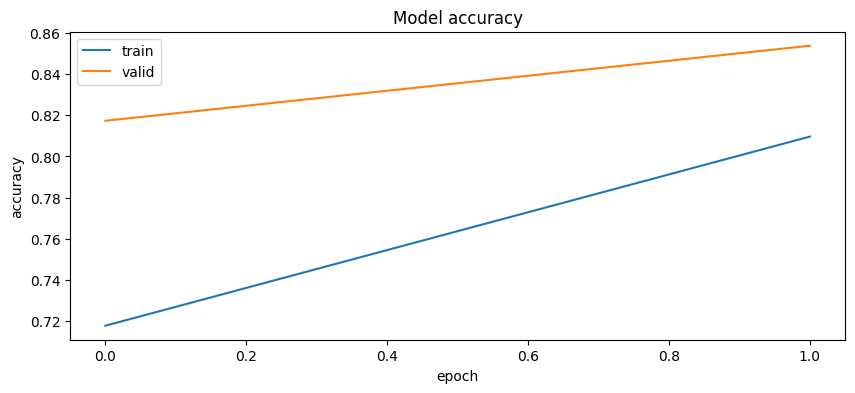

In [ ]:
plt.figure(1, figsize = (10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

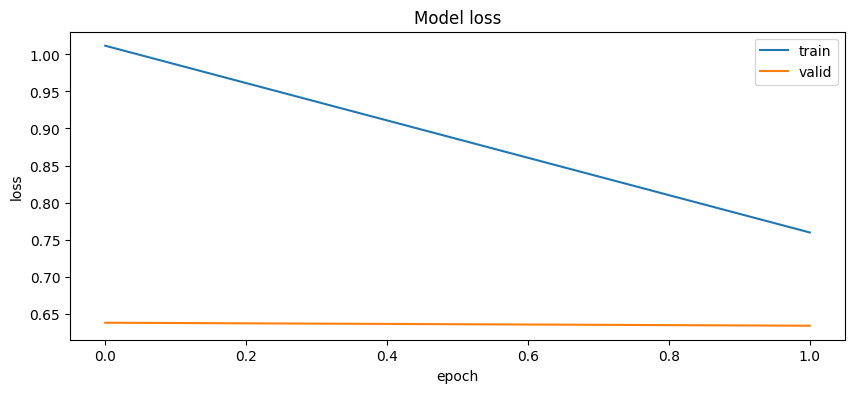

In [ ]:
plt.figure(1, figsize = (10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()